In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import igraph as ig
import torch

##### 载入并处理建网结果

In [ ]:
# us_data = pd.read_csv('../建网结果/2017_美国_平均.csv')
# us_data = pd.read_csv('../建网结果/2017_美国_传播.csv')
us_data = pd.read_csv('../建网结果/us_cas.csv', delim_whitespace=True)
us_data.columns  = ['source', 'target', 'weight']

# cn_data = pd.read_csv('../建网结果/2016_中国_平均.csv')
# cn_data = pd.read_csv('../建网结果/2016_中国_传播.csv')
cn_data = pd.read_csv('../建网结果/cn_cas.csv', delim_whitespace=True)
cn_data.columns  = ['source', 'target', 'weight']


In [40]:
us_graph = nx.Graph()

# 添加边
for _, row in us_data.iterrows():
    us_graph.add_edge(row['source'], row['target'], weight=row['weight'])

In [41]:
cn_graph = nx.Graph()

# 添加边
for _, row in cn_data.iterrows():
    cn_graph.add_edge(row['source'], row['target'], weight=row['weight'])

##### 加权改，包含remove cost，GCC

In [42]:
# us_remove_cost = {}
us_remove_cost = dict(us_graph.degree())
us_remove_cost_sum = sum(us_remove_cost.values())

# cn_remove_cost = {}
cn_remove_cost = dict(cn_graph.degree())
cn_remove_cost_sum = sum(cn_remove_cost.values())

# print(us_remove_cost)
# print(list(us_graph.nodes()))


def GCC(graph):#加权图的最大联通子图的大小
    G = graph
    components = list(nx.connected_components(G))
    max_weight_sum = 0

    for component in components:
        subgraph = G.subgraph(component)
        weight_sum = sum(data['weight'] for _, _, data in subgraph.edges(data=True))
        if weight_sum > max_weight_sum:
            max_weight_sum = weight_sum

    return max_weight_sum

##### 单纯的基本方法

In [43]:
def HXA(g, method):
    G = g.copy()
    if method == 'HDA':
        dc = nx.degree_centrality(G)
    elif method == 'HBA':
        dc = nx.betweenness_centrality(G)
    elif method == 'HCA':
        dc = nx.closeness_centrality(G)
    elif method == 'HPRA':
        dc = nx.pagerank(G)

    sol = sorted(dc.items(), key=lambda x: x[1], reverse=True)
    return sol

def d_HXA(g, method):
    sol = []
    G = g.copy()
    while (nx.number_of_edges(G)>0):
        if method == 'HDA':
            dc = nx.degree_centrality(G)
        elif method == 'BI':
            dc = nx.betweenness_centrality(G)
        elif method == 'HCA':
            dc = nx.closeness_centrality(G)
        elif method == 'HPRA':
            dc = nx.pagerank(G)
        keys = list(dc.keys())
        values = list(dc.values())
        maxTag = np.argmax(values)
        node = keys[maxTag]
        sol.append(node)
        G.remove_node(node)
    return sol

##### 包含了攻击和CI

In [44]:
# CI
def cal_collective_influence_igraph(G, l):
    g = ig.Graph.from_networkx(G)
    CI = {}
    for i in G.nodes():
        ball_i_r = set(g.neighborhood(i, order=l))  # 距离节点i最短距离为小于等于l的节点（包含自身）组成的集合
        if ball_i_r != None:
            ball_i_r.remove(i)
        kj = [g.degree(j) - 1 for j in ball_i_r]
        if g.degree(i) <= 1:
            CIi = 0
        else:
            CIi = (g.degree(i) - 1) * sum(kj)
        CI[i] = CIi

    return CI

# #RatioCut
# import scipy
# def i_ratiocut(G):
#     # Compute the Laplacian matrix
#     L = nx.laplacian_matrix(G).toarray()

#     # Compute eigenvalues and eigenvectors
#     eigenvalues, eigenvectors = scipy.linalg.eigh(L)

#     # Find the Fiedler vector (the second smallest eigenvector)
#     fiedler_vector = eigenvectors[:, np.argsort(eigenvalues)[1]]

#     # Partition the graph
#     partition_a = [i for i in range(len(fiedler_vector)) if fiedler_vector[i] < 0]
#     partition_b = [i for i in range(len(fiedler_vector)) if fiedler_vector[i] >= 0]

#     # Calculate the RatioCut value
#     cut = len([edge for edge in G.edges() if (edge[0] in partition_a and edge[1] in partition_b) or (edge[0] in partition_b and edge[1] in partition_a)])
#     if len(partition_a) == 0 and len(partition_b) == 0:
#         ratio_cut = 0
#     elif len(partition_a) == 0:
#         ratio_cut = 0 + cut / len(partition_b)
#     elif len(partition_b) == 0:
#         ratio_cut = cut / len(partition_a) + 0
#     else:
#         ratio_cut = cut / len(partition_a) + cut / len(partition_b)
#     return ratio_cut

# def ratiocut(G):
#     rc_val = {}
#     rc = i_ratiocut(G)
#     temp_G = G.copy()
#     for i in G.nodes:
#         if temp_G.number_of_nodes() <=2:
#             break
#         temp_G.remove_node(i)
#         rc_val[i] = rc - i_ratiocut(temp_G)
#     sol = sorted(rc_val.items(), key=lambda x: x[1], reverse=True)
#     return sol

#bi
def bi(G):
    # Initialize betweenness centrality scores
    betweenness = {node: 0.0 for node in G.nodes()}
    
    # Calculate initial betweenness centrality
    initial_betweenness = nx.betweenness_centrality(G)
    
    # Iterate over each node in reverse order of their betweenness centrality
    for node, _ in sorted(initial_betweenness.items(), key=lambda x: x[1], reverse=True):
        # Remove the node from the graph
        G_removed = G.copy()
        G_removed.remove_node(node)
        
        # Calculate betweenness centrality of remaining nodes
        remaining_betweenness = nx.betweenness_centrality(G_removed)
        
        # Update betweenness centrality scores
        for n in remaining_betweenness:
            if n != node:
                betweenness[n] += (initial_betweenness[n] - remaining_betweenness[n])
    
    # return betweenness
    sol = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)
    # print(nx.number_of_nodes(G) - len(sol))
    return sol
    


# 在初始网络的基础上按指标的大小移除节点
def intentional_attack_initial_network(G, rn, importance_sequence):
    order_nodes = list(importance_sequence.keys())
    G.remove_nodes_from(order_nodes[:rn])
    return G


# 在当前网络的基础上按度的大小移除点(HDA)
def intentional_attack_current_network_degree(G, step):
    # 注意G是当前网络
    deg = dict(G.degree())
    importance_sequence = dict(sorted(deg.items(), key=lambda x: x[1], reverse=True))
    order_nodes = list(importance_sequence.keys())
    G.remove_nodes_from(order_nodes[:step])

    return G


# 在当前网络的基础上按CI的大小移除点(CIA)
def intentional_attack_current_network_CI(G, step):
    mapping = dict(zip(G, range(len(G.nodes()))))
    G = nx.relabel_nodes(G, mapping)
    # 注意G是当前网络
    l = 3
    CI = cal_collective_influence_igraph(G, l)
    importance_sequence = dict(sorted(CI.items(), key=lambda x: x[1], reverse=True))
    order_nodes = list(importance_sequence.keys())
    G.remove_nodes_from(order_nodes[:step])

    return G

In [45]:
hba_nodes = []


def intentional_attack_current_network_HBA(G, step):
    # mapping = dict(zip(G, range(len(G.nodes()))))
    # G = nx.relabel_nodes(G, mapping)
    hba_sequence = nx.betweenness_centrality(G)
    importance_sequence = dict(sorted(hba_sequence.items(), key=lambda x: x[1], reverse=True))
    order_nodes = list(importance_sequence.keys())

    hba_nodes.extend(order_nodes[:step])

    G.remove_nodes_from(order_nodes[:step])

    return G

##### 攻击程序

In [46]:
# 静态攻击主程序
def get_Sq_initial_network(G, n, step, nums, Sq0, importance_sequence, func, remove_cost_sum):
    c = 0
    S_q = np.zeros(nums)
    S_q[0] = 1
    q = np.zeros(nums)
    q[0] = 0

    while True:
        G0 = G.copy()
        c = c + 1
        if c == nums:
            break
        IA_G = func(G0, step*c, importance_sequence)

        if len(IA_G.nodes()) == 1:
            break

        # Gcc = sorted(nx.connected_components(IA_G), key=len, reverse=True)
        # if len(Gcc) == 0:
        #     break
        # LCC = IA_G.subgraph(Gcc[0])
        # n_LCC = len(LCC.nodes)
        # # 计算去点后最大连通集团占网络总节点的比例
        # S_q[c] = n_LCC / n
        S_q[c] = GCC(IA_G)/GCC(G)
        q[c] = 1 - (sum(dict(IA_G.degree()).values())/remove_cost_sum)

    return S_q, q


# 动态攻击主程序
def get_Sq_current_network(G, n, nums, step, Sq0, func, remove_cost_sum):
    c = 0
    S_q = np.zeros(nums)
    S_q[0] = 1
    q = np.zeros(nums)
    q[0] = 0
    G_0 = G.copy()

    while True:
        c = c + 1
        if c == nums:
            break
        IA_G = func(G, step)
        G = IA_G.copy()

        if len(IA_G.nodes()) == 1:
            break

        # Gcc = sorted(nx.connected_components(IA_G), key=len, reverse=True)
        # if len(Gcc) == 0:
        #     break
        # LCC = IA_G.subgraph(Gcc[0])
        # n_LCC = len(LCC.nodes)
        # # 计算去点后最大连通集团占网络总节点的比例
        # S_q[c] = n_LCC / n
        S_q[c] = GCC(IA_G)/GCC(G_0)
        q[c] = 1 - (sum(dict(IA_G.degree()).values())/remove_cost_sum)

    return S_q, q

##### 攻击前处理，终止值为us_n_end, 步长为us_step现在设为1, us_nums为攻击次数，值大概为终止值除以步长。cn同理。

###### 美国

In [47]:
us_mapping = dict(zip(us_graph, range(len(us_graph.nodes()))))
us_graph = nx.relabel_nodes(us_graph, us_mapping)

# print(us_graph.nodes)

us_n0 = nx.number_of_nodes(us_graph)
print(nx.number_of_nodes(us_graph), nx.number_of_edges(us_graph))

# us_Gcc = sorted(nx.connected_components(us_graph), key=len, reverse=True)
# 得到初始网络的最大连通组件的相对大小
# us_LCC = us_graph.subgraph(us_Gcc[0])
# us_n_LCC = len(us_LCC.nodes)
# us_Sq0 = us_n_LCC / us_n0
us_Sq0 = GCC(us_graph)


# us_n_end = int(0.25 * us_n0)#平均的终止点
# us_n_end = int(0.2 * us_n0)#传播终止点
us_n_end = us_n0#cas

# us_step = int(us_n_end / 20)
us_step = 1
print(us_step)

if us_n_end % us_step == 0:
    us_nums = int(us_n_end / us_step)
else:
    us_nums = int(us_n_end / us_step) + 1

# us_q = np.linspace(0, us_n_end, us_nums) / us_n0


# 初始网络的度排序字典
us_deg = dict(us_graph.degree())
us_sorted_deg = dict(sorted(us_deg.items(), key=lambda x: x[1], reverse=True))

# 初始网络的us_CI排序字典
us_CI = cal_collective_influence_igraph(us_graph, 3)
us_sorted_CI = dict(sorted(us_CI.items(), key=lambda x: x[1], reverse=True))

315 47712
1


###### CN

In [48]:
cn_mapping = dict(zip(cn_graph, range(len(cn_graph.nodes()))))
cn_graph = nx.relabel_nodes(cn_graph, cn_mapping)

# print(cn_graph.nodes)

cn_n0 = nx.number_of_nodes(cn_graph)
print(nx.number_of_nodes(cn_graph), nx.number_of_edges(cn_graph))

# cn_Gcc = sorted(nx.connected_components(cn_graph), key=len, reverse=True)
# # 得到初始网络的最大连通组件的相对大小
# cn_LCC = cn_graph.subgraph(cn_Gcc[0])
# cn_n_LCC = len(cn_LCC.nodes)
# cn_Sq0 = cn_n_LCC / cn_n0
cn_Sq0 = GCC(cn_graph)

# cn_n_end = int(0.5 * cn_n0)#平均终止点
# cn_n_end = int(0.3 * cn_n0)#传播终止点
cn_n_end = cn_n0#cas终止点
# cn_step = int(cn_n_end / 20)
cn_step = 1
print(cn_step)

if cn_n_end % cn_step == 0:
    cn_nums = int(cn_n_end / cn_step)
else:
    cn_nums = int(cn_n_end / cn_step) + 1

# cn_q = np.linspace(0, cn_n_end, cn_nums) / cn_n0


# 初始网络的度排序字典
cn_deg = dict(cn_graph.degree())
cn_sorted_deg = dict(sorted(cn_deg.items(), key=lambda x: x[1], reverse=True))

# 初始网络的CI排序字典
cn_CI = cal_collective_influence_igraph(cn_graph, 3)
cn_sorted_CI = dict(sorted(cn_CI.items(), key=lambda x: x[1], reverse=True))

265 26796
1


##### 其他基线方法

In [49]:
us_sorted_HBA = dict(HXA(us_graph, 'HBA'))
us_sorted_HCA = dict(HXA(us_graph, 'HCA'))
us_sorted_HPRA = dict(HXA(us_graph, 'HPRA'))
# us_sorted_RC = dict(ratiocut(us_graph))
# us_sorted_BI = dict(bi(us_graph))
print(us_mapping)

{'AEX': 0, 'AMA': 1, 'ATW': 2, 'AVL': 3, 'BQN': 4, 'BTM': 5, 'CDC': 6, 'CHO': 7, 'CSG': 8, 'DAB': 9, 'EVV': 10, 'EYW': 11, 'FAI': 12, 'FSD': 13, 'GNV': 14, 'GPT': 15, 'GRB': 16, 'GTR': 17, 'GUM': 18, 'ISP': 19, 'LBB': 20, 'LIH': 21, 'MEI': 22, 'MEM': 23, 'MLI': 24, 'MOB': 25, 'MQT': 26, 'MSN': 27, 'MYR': 28, 'PNS': 29, 'ROA': 30, 'SBN': 31, 'SJU': 32, 'SYR': 33, 'TWF': 34, 'ACT': 35, 'ACV': 36, 'ACY': 37, 'ALB': 38, 'AUS': 39, 'BDL': 40, 'BTR': 41, 'BUF': 42, 'CAE': 43, 'CLE': 44, 'CMH': 45, 'CRW': 46, 'DFW': 47, 'DTW': 48, 'ECP': 49, 'FLL': 50, 'FNT': 51, 'GEG': 52, 'HOU': 53, 'HPN': 54, 'JAC': 55, 'JAX': 56, 'JFK': 57, 'LAN': 58, 'LEX': 59, 'LGA': 60, 'MAF': 61, 'MCO': 62, 'MDW': 63, 'MKE': 64, 'MLB': 65, 'OAK': 66, 'OKC': 67, 'OMA': 68, 'ORD': 69, 'PSP': 70, 'PVD': 71, 'RIC': 72, 'SAN': 73, 'SAT': 74, 'SDF': 75, 'SEA': 76, 'SGF': 77, 'STL': 78, 'TUL': 79, 'VPS': 80, 'ABQ': 81, 'ABY': 82, 'ANC': 83, 'ASE': 84, 'BNA': 85, 'BOS': 86, 'BTV': 87, 'BUR': 88, 'CHA': 89, 'CHS': 90, 'COS': 9

In [50]:
cn_sorted_HBA = dict(HXA(cn_graph, 'HBA'))
cn_sorted_HCA = dict(HXA(cn_graph, 'HCA'))
cn_sorted_HPRA = dict(HXA(cn_graph, 'HPRA'))
# cn_sorted_RC = dict(ratiocut(cn_graph))
# cn_sorted_BI = dict(bi(cn_graph))

换网络要跟着换文件名字

In [51]:
# us_pr_list = {i: us_sorted_HPRA[j] for i, j in us_mapping.items()}
# cn_pr_list = {i: cn_sorted_HPRA[j] for i, j in cn_mapping.items()}

# tmp_us_df = pd.DataFrame(list(us_pr_list.items()), columns=['Airport', 'Value'])
# tmp_us_df = tmp_us_df.sort_values(by='Value')
# tmp_us_df.to_csv('us_pr_因果.csv', index=False)

# tmp_cn_df = pd.DataFrame(list(cn_pr_list.items()), columns=['Airport', 'Value'])
# tmp_cn_df = tmp_cn_df.sort_values(by='Value')
# tmp_cn_df.to_csv('cn_pr_因果.csv', index=False)

##### 攻击

###### 美国

In [52]:
# HD（静态）
us_1 = get_Sq_initial_network(us_graph, us_n0, us_step, us_nums, us_Sq0, us_sorted_deg, intentional_attack_initial_network, us_remove_cost_sum)
us_q1 = us_1[1]
us_S_q1 = us_1[0]
# HDA（动态）
us_2 = get_Sq_current_network(us_graph, us_n0, us_nums, us_step, us_Sq0, intentional_attack_current_network_degree, us_remove_cost_sum)
us_q2 = us_2[1]
us_S_q2 = us_2[0]
# CI（静态）
us_3 = get_Sq_initial_network(us_graph, us_n0, us_step, us_nums, us_Sq0, us_sorted_CI, intentional_attack_initial_network, us_remove_cost_sum)
us_q3 = us_3[1]
us_S_q3 = us_3[0]
# CIA（动态）
us_4 = get_Sq_current_network(us_graph, us_n0, us_nums, us_step, us_Sq0, intentional_attack_current_network_CI, us_remove_cost_sum)
us_q4 = us_4[1]
us_S_q4 = us_4[0]

# HBA（静态）
us_5 = get_Sq_initial_network(us_graph, us_n0, us_step, us_nums, us_Sq0, us_sorted_HBA, intentional_attack_initial_network, us_remove_cost_sum)
us_q5 = us_5[1]
us_S_q5 = us_5[0]
# HCA（静态）
us_6 = get_Sq_initial_network(us_graph, us_n0, us_step, us_nums, us_Sq0, us_sorted_HCA, intentional_attack_initial_network, us_remove_cost_sum)
us_q6 = us_6[1]
us_S_q6 = us_6[0]
# HPRA（静态）
us_7 = get_Sq_initial_network(us_graph, us_n0, us_step, us_nums, us_Sq0, us_sorted_HPRA, intentional_attack_initial_network, us_remove_cost_sum)
us_q7 = us_7[1]
us_S_q7 = us_7[0]
# # RatioCut（静态）
# us_S_q8 = get_Sq_initial_network(us_graph, us_n0, us_step, us_nums, us_Sq0, us_sorted_RC, intentional_attack_initial_network)

#######################
# us_8 = get_Sq_initial_network(us_graph, us_n0, us_step, us_nums, us_Sq0, us_sorted_BI, intentional_attack_initial_network, us_remove_cost_sum)
# us_q8 = us_8[1]
# us_S_q8 = us_8[0]
us_8 = get_Sq_current_network(us_graph, us_n0, us_nums, us_step, us_Sq0, intentional_attack_current_network_HBA, us_remove_cost_sum)
us_q8 = us_8[1]
us_S_q8 = us_8[0]

In [53]:
reverse_mapping = {v: k for k, v in us_mapping.items()}
us_pr_list = [reverse_mapping[num] for num in hba_nodes]
tmp_us_df = pd.DataFrame(us_pr_list, columns=['Airport'])
tmp_us_df.to_csv('us_bi_因果.csv', index=False)
hba_nodes = []

In [15]:
print(us_q8)

[0.         0.13503499 0.18937834 0.23878139 0.29394813 0.33758748
 0.38081515 0.41580897 0.4405105  0.47468094 0.50679292 0.54137505
 0.57225196 0.60065871 0.62824207 0.64512145 0.65170852 0.67723343
 0.70317003 0.72293125 0.74186908 0.76286538 0.77645121 0.79333059
 0.81062166 0.82297242 0.83861671 0.84726225 0.86208316 0.86743516
 0.87155208 0.88307946 0.89501853 0.90325237 0.90942775 0.91889667
 0.92671881 0.93618773 0.94359819 0.94771511 0.94977357 0.95306711
 0.95553726 0.9584191  0.96006587 0.96171264 0.96459448 0.96582956
 0.96788802 0.97035817 0.97200494 0.97282832 0.97365171 0.97529848
 0.97612186 0.97694524 0.97776863 0.97859201 0.9794154  0.98023878
 0.98106217 0.98188555 0.98270893 0.98353232 0.9843557  0.98517909
 0.98600247 0.98682585 0.98682585 0.98723755 0.98723755 0.98723755
 0.98723755 0.98723755 0.98723755 0.98723755 0.98723755 0.98723755
 0.98723755 0.98723755 0.98723755 0.98723755 0.98723755 0.98723755
 0.98723755 0.98764924 0.98764924 0.98764924 0.98806093 0.9880

In [ ]:
print(us_S_q8)

[1.00000000e+00 9.38605404e-01 8.81266412e-01 8.43782677e-01
 8.04927332e-01 7.68551023e-01 7.36251743e-01 6.89891031e-01
 5.70585599e-01 5.48764981e-01 5.10275196e-01 4.91133020e-01
 4.59869177e-01 4.40624524e-01 4.20224545e-01 4.11196463e-01
 4.06912307e-01 3.93312386e-01 3.69406570e-01 3.38993660e-01
 3.18558999e-01 3.05427912e-01 2.97103534e-01 2.79828618e-01
 2.69026709e-01 2.37906879e-01 2.24111290e-01 2.18061177e-01
 2.07422288e-01 1.99400396e-01 1.82834195e-01 1.66208632e-01
 1.44306803e-01 1.37724945e-01 1.29593083e-01 1.22971608e-01
 7.75703626e-02 7.75703626e-02 7.75703626e-02 7.75703626e-02
 7.75703626e-02 7.75703626e-02 7.75703626e-02 7.75703626e-02
 7.75703626e-02 7.75703626e-02 7.75703626e-02 4.31730452e-02
 4.31730452e-02 4.31730452e-02 4.31730452e-02 4.05746110e-02
 4.05746110e-02 4.05746110e-02 4.05746110e-02 4.05746110e-02
 4.05746110e-02 4.05746110e-02 4.05746110e-02 4.05746110e-02
 1.95187546e-02 1.95187546e-02 1.95187546e-02 1.95187546e-02
 1.95187546e-02 1.951875

###### 中国

In [54]:
# HD（静态）
cn_1 = get_Sq_initial_network(cn_graph, cn_n0, cn_step, cn_nums, cn_Sq0, cn_sorted_deg, intentional_attack_initial_network, cn_remove_cost_sum)
cn_q1 = cn_1[1]
cn_S_q1 = cn_1[0]
# HDA（动态）
cn_2 = get_Sq_current_network(cn_graph, cn_n0, cn_nums, cn_step, cn_Sq0, intentional_attack_current_network_degree, cn_remove_cost_sum)
cn_q2 = cn_2[1]
cn_S_q2 = cn_2[0]
# CI（静态）
cn_3 = get_Sq_initial_network(cn_graph, cn_n0, cn_step, cn_nums, cn_Sq0, cn_sorted_CI, intentional_attack_initial_network, cn_remove_cost_sum)
cn_q3 = cn_3[1]
cn_S_q3 = cn_3[0]
# CIA（动态）
cn_4 = get_Sq_current_network(cn_graph, cn_n0, cn_nums, cn_step, cn_Sq0, intentional_attack_current_network_CI, cn_remove_cost_sum)
cn_q4 = cn_4[1]
cn_S_q4 = cn_4[0]

# HBA（静态）
cn_5 = get_Sq_initial_network(cn_graph, cn_n0, cn_step, cn_nums, cn_Sq0, cn_sorted_HBA, intentional_attack_initial_network, cn_remove_cost_sum)
cn_q5 = cn_5[1]
cn_S_q5 = cn_5[0]
# HCA（静态）
cn_6 = get_Sq_initial_network(cn_graph, cn_n0, cn_step, cn_nums, cn_Sq0, cn_sorted_HCA, intentional_attack_initial_network, cn_remove_cost_sum)
cn_q6 = cn_6[1]
cn_S_q6 = cn_6[0]
# HPRA（静态）
cn_7 = get_Sq_initial_network(cn_graph, cn_n0, cn_step, cn_nums, cn_Sq0, cn_sorted_HPRA, intentional_attack_initial_network, cn_remove_cost_sum)
cn_q7 = cn_7[1]
cn_S_q7 = cn_7[0]
# # RatioCut（静态）
# cn_S_q8 = get_Sq_initial_network(cn_graph, cn_n0, cn_step, cn_nums, cn_Sq0, cn_sorted_RC, intentional_attack_initial_network)
# BI（动态用静态跑）
# cn_8 = get_Sq_initial_network(cn_graph, cn_n0, cn_step, cn_nums, cn_Sq0, cn_sorted_BI, intentional_attack_initial_network, cn_remove_cost_sum)
# cn_q8 = cn_8[1]
# cn_S_q8 = cn_8[0]

cn_8 = get_Sq_current_network(cn_graph, cn_n0, cn_nums, cn_step, cn_Sq0, intentional_attack_current_network_HBA, cn_remove_cost_sum)
cn_q8 = cn_8[1]
cn_S_q8 = cn_8[0]

In [55]:
reverse_mapping = {v: k for k, v in cn_mapping.items()}
cn_pr_list = [reverse_mapping[num] for num in hba_nodes]
tmp_cn_df = pd.DataFrame(cn_pr_list, columns=['Airport'])
tmp_cn_df.to_csv('cn_bi_因果.csv', index=False)
hba_nodes = []

##### 美化基本方法曲线

In [18]:
def mapfunc(x, y, step):
    x_sampled = []
    y_sampled = []
    x_sampled.append(x[0])
    y_sampled.append(y[0])
    tmp = 0
    for i in range(1, len(x)):
        if x[i]>tmp:
            if y[i] != 1:
                tmp += step
                x_sampled.append(x[i])
                y_sampled.append(y[i])
    return x_sampled, y_sampled

In [19]:
us_q1_new, us_S_q1_new = mapfunc(us_q1, us_S_q1, 0.08)
us_q2_new, us_S_q2_new = mapfunc(us_q2, us_S_q2, 0.08)
us_q3_new, us_S_q3_new = mapfunc(us_q3, us_S_q3, 0.08)
us_q4_new, us_S_q4_new = mapfunc(us_q4, us_S_q4, 0.08)
us_q5_new, us_S_q5_new = mapfunc(us_q5, us_S_q5, 0.08)
us_q6_new, us_S_q6_new = mapfunc(us_q6, us_S_q6, 0.08)
us_q7_new, us_S_q7_new = mapfunc(us_q7, us_S_q7, 0.08)
us_q8_new, us_S_q8_new = mapfunc(us_q8, us_S_q8, 0.08)

cn_q1_new, cn_S_q1_new = mapfunc(cn_q1, cn_S_q1, 0.08)
cn_q2_new, cn_S_q2_new = mapfunc(cn_q2, cn_S_q2, 0.08)
cn_q3_new, cn_S_q3_new = mapfunc(cn_q3, cn_S_q3, 0.08)
cn_q4_new, cn_S_q4_new = mapfunc(cn_q4, cn_S_q4, 0.08)
cn_q5_new, cn_S_q5_new = mapfunc(cn_q5, cn_S_q5, 0.08)
cn_q6_new, cn_S_q6_new = mapfunc(cn_q6, cn_S_q6, 0.08)
cn_q7_new, cn_S_q7_new = mapfunc(cn_q7, cn_S_q7, 0.08)
cn_q8_new, cn_S_q8_new = mapfunc(cn_q8, cn_S_q8, 0.08)

In [ ]:
us_S_q1_new

In [ ]:
us_S_q8_new

##### 画图，us_q1为横坐标, us_S_q1为纵坐标

美国平均

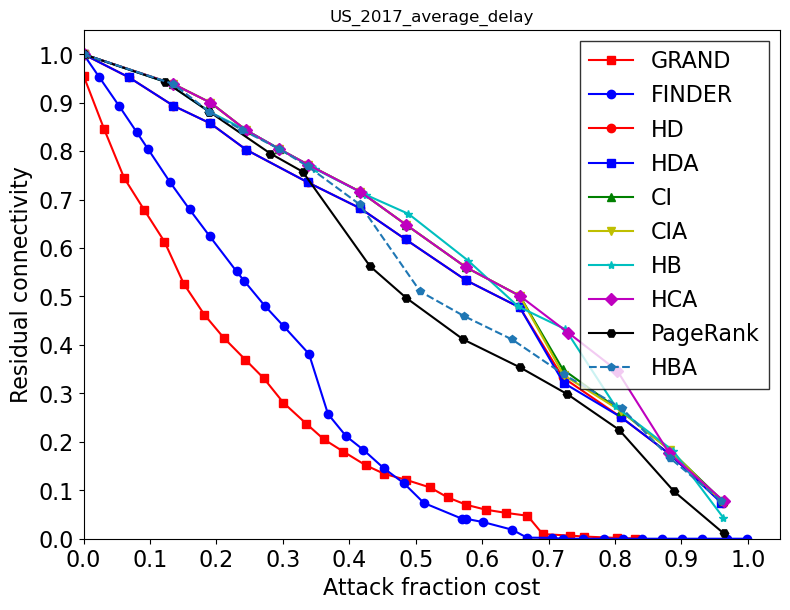

In [24]:
# plt.clf()
plt.figure(figsize=(8, 6))
#GRAND接口
x_grand,y_grand = torch.load('x_2017_美国_平均.pt'),torch.load('y_2017_美国_平均.pt')
x_grand_new, y_grand_new = mapfunc(x_grand,y_grand, 0.03)
plt.plot(x_grand_new,y_grand_new, "rs-", label = 'GRAND')

#FINDER接口
finder_result = pd.read_csv('finder结果/us_avg.csv')
x_finder = finder_result['x'].tolist()
y_finder = finder_result['y'].tolist()
# for i in range(0,len(y_finder)):
#     y_finder[i] = y_finder[i]/us_gcc
# x_finder[0] = 0
x_finder_new, y_finder_new = mapfunc(x_finder,y_finder, 0.03)
plt.plot(x_finder_new,y_finder_new, "bo-", label = 'FINDER')


plt.plot(us_q1_new, us_S_q1_new, "ro-", label='HD')
plt.plot(us_q2_new, us_S_q2_new, "bs-", label='HDA')
plt.plot(us_q3_new, us_S_q3_new, "g^-", label='CI')
plt.plot(us_q4_new, us_S_q4_new, "yv-", label='CIA')
plt.plot(us_q5_new, us_S_q5_new, "c*-", label='HB') 
plt.plot(us_q6_new, us_S_q6_new, "mD-", label='HCA')
plt.plot(us_q7_new, us_S_q7_new, "kH-", label='PageRank')
plt.plot(us_q8_new, us_S_q8_new, "p--", label='HBA')


plt.legend(loc=1, edgecolor="black", fontsize=16, fancybox=False)
plt.xlabel("Attack fraction cost", fontsize=16)
plt.ylabel("Residual connectivity", fontsize=16)
plt.tick_params(labelsize=16)

plt.xlim(left=0)
# plt.xlim(0, 0.2)
plt.ylim(bottom=0)
# plt.xticks(np.linspace(0, 0.4, 6))
plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))

plt.tight_layout()
plt.title('US_2017_average_delay')
plt.show()

中国平均

<Figure size 640x480 with 0 Axes>

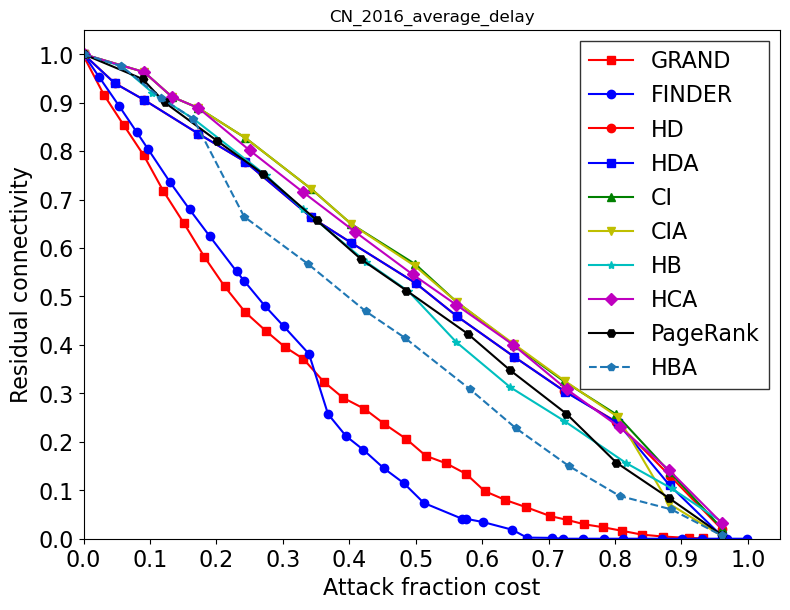

In [25]:
plt.clf()
plt.figure(figsize=(8, 6))
x_grand,y_grand = torch.load('x_2016_中国_平均.pt'),torch.load('y_2016_中国_平均.pt')
x_grand_mew, y_grand_mew = mapfunc(x_grand,y_grand, 0.03)
plt.plot(x_grand_mew,y_grand_mew, "rs-", label = 'GRAND')

finder_result = pd.read_csv('finder结果/cn_avg.csv')
# x_finder = finder_result['x'].tolist()
# y_finder = finder_result['y'].tolist()
# for i in range(0,len(y_finder)):
#     y_finder[i] = y_finder[i]/cn_gcc
# x_finder[0] = 0
x_finder_mew, y_finder_mew = mapfunc(x_finder,y_finder, 0.03)
plt.plot(x_finder_new,y_finder_new, "bo-", label = 'FINDER')

plt.plot(cn_q1_new, cn_S_q1_new, "ro-", label='HD')
plt.plot(cn_q2_new, cn_S_q2_new, "bs-", label='HDA')
plt.plot(cn_q3_new, cn_S_q3_new, "g^-", label='CI')
plt.plot(cn_q4_new, cn_S_q4_new, "yv-", label='CIA')
plt.plot(cn_q5_new, cn_S_q5_new, "c*-", label='HB') 
plt.plot(cn_q6_new, cn_S_q6_new, "mD-", label='HCA')
plt.plot(cn_q7_new, cn_S_q7_new, "kH-", label='PageRank')
plt.plot(cn_q8_new, cn_S_q8_new, "p--", label='HBA')


plt.legend(loc=1, edgecolor="black", fontsize=16, fancybox=False)
plt.xlabel("Attack fraction cost", fontsize=16)
plt.ylabel("Residual connectivity", fontsize=16)
plt.tick_params(labelsize=16)


plt.xlim(left=0)
# plt.xlim(0, 0.3)
plt.ylim(bottom=0)
# plt.xticks(np.linspace(0, 0.4, 11))
plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))

plt.tight_layout()
plt.title('CN_2016_average_delay')
plt.show()

##### 传播画图

美国传播

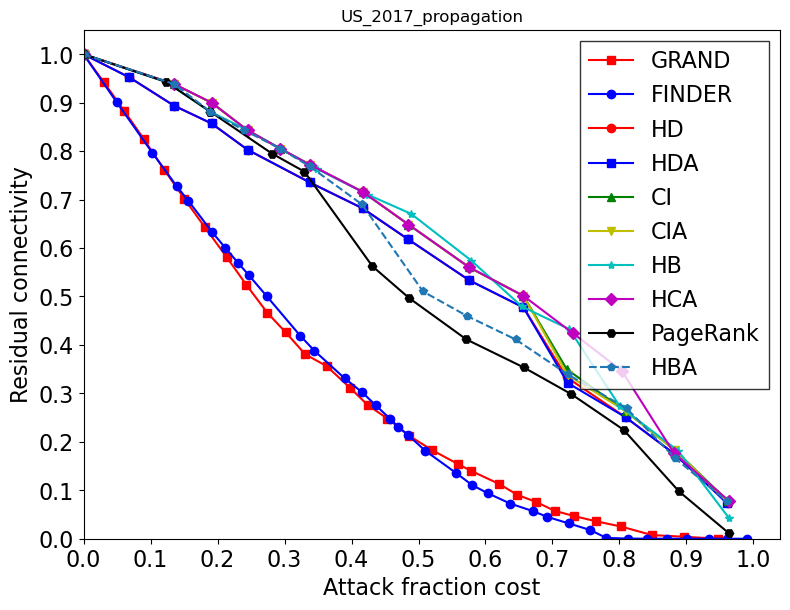

In [23]:
# plt.clf()
plt.figure(figsize=(8, 6))
x_grand,y_grand = torch.load('x_2017_美国_传播.pt'),torch.load('y_2017_美国_传播.pt')
x_grand_new, y_grand_new = mapfunc(x_grand,y_grand, 0.03)
plt.plot(x_grand_new,y_grand_new, "rs-", label = 'GRAND')

finder_result = pd.read_csv('finder结果/us_prop.csv')
x_finder = finder_result['x'].tolist()
y_finder = finder_result['y'].tolist()
# for i in range(0,len(y_finder)):
#     y_finder[i] = y_finder[i]/us_gcc
# x_finder[0] = 0
x_finder_new, y_finder_new = mapfunc(x_finder,y_finder, 0.03)

plt.plot(x_finder_new,y_finder_new, "bo-", label = 'FINDER')

plt.plot(us_q1_new, us_S_q1_new, "ro-", label='HD')
plt.plot(us_q2_new, us_S_q2_new, "bs-", label='HDA')
plt.plot(us_q3_new, us_S_q3_new, "g^-", label='CI')
plt.plot(us_q4_new, us_S_q4_new, "yv-", label='CIA')
plt.plot(us_q5_new, us_S_q5_new, "c*-", label='HBA') 
plt.plot(us_q6_new, us_S_q6_new, "mD-", label='HCA')
plt.plot(us_q7_new, us_S_q7_new, "kH-", label='PageRank')
plt.plot(us_q8_new, us_S_q8_new, "p--", label='BI*')


plt.legend(loc=1, edgecolor="black", fontsize=16, fancybox=False)
plt.xlabel("Attack fraction cost", fontsize=16)
plt.ylabel("Residual connectivity", fontsize=16)
plt.tick_params(labelsize=16)

plt.xlim(left=0)
# plt.ylim(bottom=0)
# plt.xlim(0, 0.2)
plt.ylim(bottom=0)
# plt.xticks(np.linspace(0, 0.2, 6))
plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))

plt.tight_layout()
plt.title('US_2017_propagation')
plt.show()

中国传播

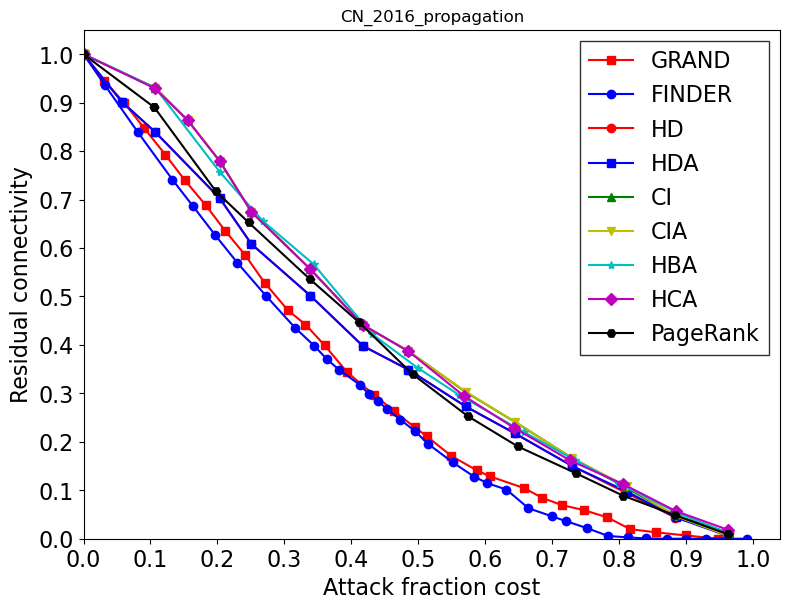

In [20]:
# plt.clf()
plt.figure(figsize=(8, 6))
x_grand,y_grand = torch.load('x_2016_中国_传播.pt'),torch.load('y_2016_中国_传播.pt')
x_grand_new, y_grand_new = mapfunc(x_grand,y_grand, 0.03)
plt.plot(x_grand_new,y_grand_new, "rs-", label = 'GRAND')

finder_result = pd.read_csv('finder结果/cn_prop.csv')
x_finder = finder_result['x'].tolist()
y_finder = finder_result['y'].tolist()
# for i in range(0,len(y_finder)):
#     y_finder[i] = y_finder[i]/cn_gcc
# x_finder[0] = 0
x_finder_new, y_finder_new = mapfunc(x_finder,y_finder, 0.03)
plt.plot(x_finder_new,y_finder_new, "bo-", label = 'FINDER')

plt.plot(cn_q1_new, cn_S_q1_new, "ro-", label='HD')
plt.plot(cn_q2_new, cn_S_q2_new, "bs-", label='HDA')
plt.plot(cn_q3_new, cn_S_q3_new, "g^-", label='CI')
plt.plot(cn_q4_new, cn_S_q4_new, "yv-", label='CIA')
plt.plot(cn_q5_new, cn_S_q5_new, "c*-", label='HBA') 
plt.plot(cn_q6_new, cn_S_q6_new, "mD-", label='HCA')
plt.plot(cn_q7_new, cn_S_q7_new, "kH-", label='PageRank')


plt.legend(loc=1, edgecolor="black", fontsize=16, fancybox=False)
plt.xlabel("Attack fraction cost", fontsize=16)
plt.ylabel("Residual connectivity", fontsize=16)
plt.tick_params(labelsize=16)


plt.xlim(left=0)
# plt.xlim(0, 0.3)
plt.ylim(bottom=0)
# plt.xticks(np.linspace(0, 0.3, 6))
plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))

plt.tight_layout()
plt.title('CN_2016_propagation')
plt.show()

##### 因果画图

美国因果

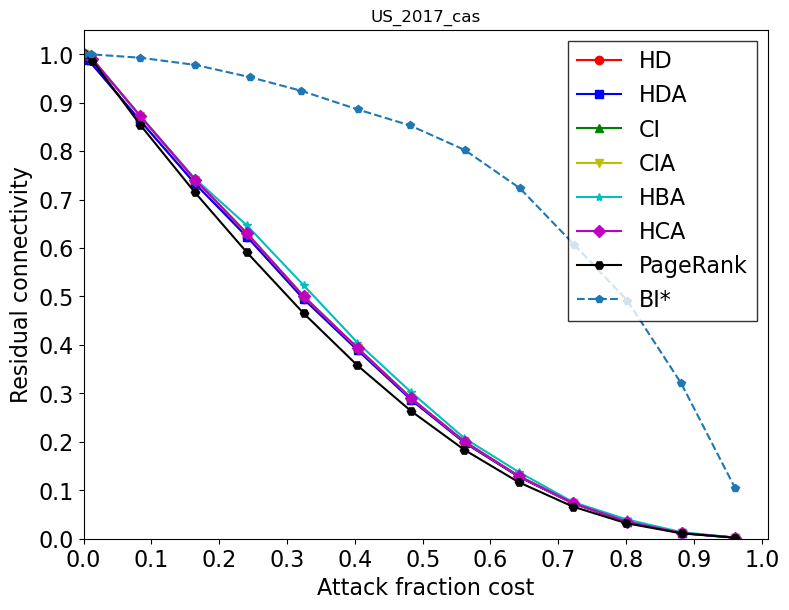

In [17]:
# plt.clf()
plt.figure(figsize=(8, 6))
# x_grand,y_grand = torch.load('x_2017_美国_传播.pt'),torch.load('y_2017_美国_传播.pt')
# x_grand_new, y_grand_new = mapfunc(x_grand,y_grand, 0.03)
# plt.plot(x_grand_new,y_grand_new, "rs-", label = 'GRAND')

# finder_result = pd.read_csv('finder结果/us_prop.csv')
# x_finder = finder_result['x'].tolist()
# y_finder = finder_result['y'].tolist()
# # for i in range(0,len(y_finder)):
# #     y_finder[i] = y_finder[i]/us_gcc
# # x_finder[0] = 0
# x_finder_new, y_finder_new = mapfunc(x_finder,y_finder, 0.03)
# plt.plot(x_finder_new,y_finder_new, "bo-", label = 'FINDER')

plt.plot(us_q1_new, us_S_q1_new, "ro-", label='HD')
plt.plot(us_q2_new, us_S_q2_new, "bs-", label='HDA')
plt.plot(us_q3_new, us_S_q3_new, "g^-", label='CI')
plt.plot(us_q4_new, us_S_q4_new, "yv-", label='CIA')
plt.plot(us_q5_new, us_S_q5_new, "c*-", label='HBA') 
plt.plot(us_q6_new, us_S_q6_new, "mD-", label='HCA')
plt.plot(us_q7_new, us_S_q7_new, "kH-", label='PageRank')
plt.plot(us_q8_new, us_S_q8_new, "p--", label='BI*')


plt.legend(loc=1, edgecolor="black", fontsize=16, fancybox=False)
plt.xlabel("Attack fraction cost", fontsize=16)
plt.ylabel("Residual connectivity", fontsize=16)
plt.tick_params(labelsize=16)

plt.xlim(left=0)
# plt.ylim(bottom=0)
# plt.xlim(0, 0.2)
plt.ylim(bottom=0)
# plt.xticks(np.linspace(0, 0.2, 6))
plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))

plt.tight_layout()
plt.title('US_2017_cas')
plt.show()

中国因果

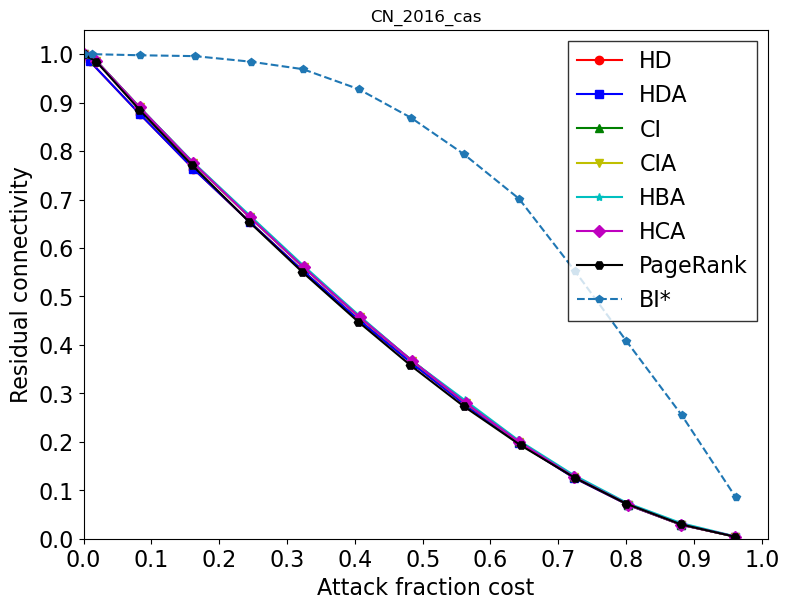

In [20]:
# plt.clf()
plt.figure(figsize=(8, 6))
# x_grand,y_grand = torch.load('x_2016_中国_平均.pt'),torch.load('y_2016_中国_平均.pt')
# x_grand_mew, y_grand_mew = mapfunc(x_grand,y_grand, 0.03)
# plt.plot(x_grand_mew,y_grand_mew, "rs-", label = 'GRAND')

# finder_result = pd.read_csv('finder结果/cn_avg.csv')
# # x_finder = finder_result['x'].tolist()
# # y_finder = finder_result['y'].tolist()
# # for i in range(0,len(y_finder)):
# #     y_finder[i] = y_finder[i]/cn_gcc
# # x_finder[0] = 0
# x_finder_mew, y_finder_mew = mapfunc(x_finder,y_finder, 0.03)
# plt.plot(x_finder_new,y_finder_new, "bo-", label = 'FINDER')

plt.plot(cn_q1_new, cn_S_q1_new, "ro-", label='HD')
plt.plot(cn_q2_new, cn_S_q2_new, "bs-", label='HDA')
plt.plot(cn_q3_new, cn_S_q3_new, "g^-", label='CI')
plt.plot(cn_q4_new, cn_S_q4_new, "yv-", label='CIA')
plt.plot(cn_q5_new, cn_S_q5_new, "c*-", label='HBA') 
plt.plot(cn_q6_new, cn_S_q6_new, "mD-", label='HCA')
plt.plot(cn_q7_new, cn_S_q7_new, "kH-", label='PageRank')
plt.plot(cn_q8_new, cn_S_q8_new, "p--", label='BI*')


plt.legend(loc=1, edgecolor="black", fontsize=16, fancybox=False)
plt.xlabel("Attack fraction cost", fontsize=16)
plt.ylabel("Residual connectivity", fontsize=16)
plt.tick_params(labelsize=16)


plt.xlim(left=0)
# plt.xlim(0, 0.3)
plt.ylim(bottom=0)
# plt.xticks(np.linspace(0, 0.4, 11))
plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))

plt.tight_layout()
plt.title('CN_2016_cas')
plt.show()